# Music Genre Classification - Tabular Audio Feature Classification Modeling
- In this notebook we seek to make predictive models that do not rely on time-frequency analysis.
- We use Spotify's API in order to collect song data to fit logistic regression and a dense neural network models to discern genre.
- This process is designed to serve as a benchmark of success for our other neural network models trained on raw audio data.

## Contents
- [Imports](#Imports)
- [Data Collection](#Data-Collection)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Modeling](#Modeling)
    - [Logistic Regression](#Logistic-Regression)
    - [Dense Neural Network (DNN)](#Dense-Neural-Network-(DNN))
- [Conclusions](#Conclusions)

### Imports

In [213]:
# Spotipy API needs to be installed to run this notebook
# !pip install Spotipy

In [214]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spotipy # Spotify API
from spotipy import SpotifyClientCredentials # Spotify API
from itertools import chain # compress lists

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Data Collection
#### Spotipy API
- Using the Spotipy API, songs will be collected using the "Top 10,000 Songs of All Time" playlist by Acclaimed Music.
- This playlist was chosen because it has a large range of songs and genres.

#### Client Authentication
- In order to interact with the Spotify API, we need client authentification.
- This can be gained by creating an account through the Spotify for developers page.

In [215]:
cid = '' #insert your own id
secret = '' #insert your own key

In [216]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
spot = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [217]:
# Loop through api calls to collect songs (100 per call)
playlist_link = 'https://open.spotify.com/playlist/1G8IpkZKobrIlXcVPoSIuf?si=f819917d1bca45b8'
playlist_uri = playlist_link.split("/")[-1].split("?")[0]
song_list = []
for i in range(0,9901,100):
    track_uris = [x["track"]["uri"]...
                  for x in spot.playlist_tracks(playlist_uri, limit= 100, offset= i)["items"]...
                  if x["track"] != None ] # exception in case "track" has a value of "None"
    
    # Append songs to song list
    song_list.append(track_uris)

In [218]:
# Condense list of lists into single list of songs
song_list = list(chain.from_iterable(song_list))

### Review example data
- Look at an example song to see its formatting.
- From this we can create a new dataset. This is required because the genres of the songs are not included in the json package that the API returns. Instead, it is held within the artist's URI.
- We will use the artist URI to determine each artist's/song's genre.
- This is limiting because artists may create songs of various genres, but we are restricted to one genre per artist.

In [219]:
# Review first sample
spot.track(song_list[0])

In [220]:
# Extract artist URI
elvis = spot.track(song_list[0])['album']['artists'][0]['uri']
elvis

In [221]:
# Extract genre from artist URI
elvis_info = spot.artist(elvis)
elvis_info['genres'][0]

#### Catch Spotipy Mistakes
- Some song links to the artist page have been deleted.
- This throws errors, so the data needs to filter out these problematic entries.

In [222]:
artist_uris = []
failed_uris = []
genres = []

In [223]:
# Test if each song has a valid link to the artist.
# If so, append uri
for i in song_list:
  try:
       artist_uri = spot.track(i)['album']['artists'][0]['uri']
       artist_uris.append(artist_uri)
       genres.append(spot.artist(artist_uri)['genres'][0])
   except:
       failed_uris.append(i)    

#### Filter URIs
- The successfully populated URIs need to be filtered from the missing values.

In [224]:
# Create list of filtered URIs
filtered_uris = [x for x in song_list if x not in failed_uris]

In [225]:
# Loop through URIs

features = []
more_failed_uris = []

for i in filtered_uris:
   try:
       track_feature = spot.audio_features(i)[0]
       features.append(track_feature)
   except:
       more_failed_uris.append(i)

In [226]:
# Loop through URIs to extract the successfully gleaned genres

refiltered_genres = []

re_filtered = [ x['uri'] for x in features if x not in failed_uris]
for i in song_list:
    artist_uri = spot.track(i)['album']['artists'][0]['uri'] 
    refiltered_genres.append(spot.artist(artist_uri)['genres'][0])
        

In [227]:
# Create a dataframe to include our features and genres
df = pd.DataFrame(data = features, columns = features[0].keys())
gen = pd.Series(refiltered_genres)
df['genre'] = gen.values

#### Cameron Watts Dataset
- Because the Spotipy API takes days to run, during testing we leveraged a pre-created dataset that follows the same collection process from Cameron Watts in the article *"Extracting Song Data From the Spotify API Using Python"*

In [230]:
# music_set = pd.read_csv('https://raw.githubusercontent.com/enjuichang/PracticalDataScience-ENCA/main/data/allsong_data.csv')

## Exploratory Data Analysis (EDA)
- Review data and features.
- Drop unnecessary features.
- Condense list of genres/sub-genres to common genres.

In [231]:
# Review all of the successfully scraped entries
music_set.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"['dance_pop', 'hip_hop', 'hip_pop', 'pop', 'po...",low,Neutral
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"['dance_pop', 'pop', 'post-teen_pop']",low,Neutral
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"['dance_pop', 'pop', 'r&b']",high,Negative
3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"['dance_pop', 'pop']",low,Neutral
4,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"['pop_rap', 'reggae_fusion']",low,Neutral


#### Drop unnecessary features
- We only care about features we can use numerically to fit our models on, so we will drop the track names, artist names, polarities, subjectivities, track popularities, and artist popularities.

In [232]:
# Drop unnecessary features
music_set = music_set.drop(columns=['id',
                                    'artist_name',
                                    'track_name',
                                    'polarity',
                                    'subjectivity',
                                    'track_pop',
                                    'artist_pop',
                                    'genres'])

#### Condense genre list
- Condense genre list down to first (main) entry.

In [233]:
# Condense genre list down to first (main) entry
music_set.genres_list = music_set['genres_list'].apply(lambda st: st[st.find("[")+1:st.find(",")])

In [234]:
# Review condense genres
music_set.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres_list
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,'dance_pop'
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,'dance_pop'
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,'dance_pop'
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,'dance_pop'
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,'pop_rap'


In [235]:
# Create a series of genre counts counts
genre_counts = music_set.genres_list.value_counts()

In [236]:
# Filters genres to those containing more than 500 entries.
# There are a remarkable amount of genres/sub-genres, so this narrows the list appropriately.
new_genres = genre_counts[genre_counts >=500].index 

In [237]:
# Creates new dataframe of only selected features
music_set_filtered = music_set[(music_set['genres_list'] != "'unknown'") & music_set['genres_list'].isin(new_genres) ]

## Modeling
- Two types of models were tested
    - Logistic Regression
    - Dense Neural Network (DNN)
- These models are created to illustrate base cases for the Spotify data.
- Specifically for the DNN, data needs to be in the correct "shape".
    - DNN: (n, n)
- Data is also split into 3 sets
    - Training set: For the model to train on
    - Validation set: For the model to compare against while training
    - Test set: A set unsees by the model until the end for final testing

In [238]:
# Define features (X) and target (y)
X = music_set_filtered.drop(columns='genres_list')
y = music_set_filtered.genres_list

In [239]:
# One-Hot Encode 'key'
X = pd.get_dummies(columns=['key'], data=X, drop_first=True)

In [240]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Print shape
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4202, 21), y training data shape: (4202,)
X validation data shape: (1801, 21), y validation data shape: (1801,)


In [241]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

### Logistic Regression
- A simple logistic regression model was constructed using no penalty and a 'lbfgs' solver.
- Max iterations were increased to allow the model to converge.

In [242]:
# Instantiate Logistic Regression Model
logreg = LogisticRegression(penalty=None, solver= 'lbfgs', max_iter=10000, random_state=42)

In [243]:
# Fit model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, penalty=None, random_state=42)

In [244]:
# Review model performance
print(" Logistic Regression ".center(30, "-"))
print(f'Training Accuracy:    {logreg.score(X_train, y_train).round(5)}')
print(f'Validation Accuracy:  {logreg.score(X_val, y_val).round(5)}')
print(f'Testing Accuracy:     {logreg.score(X_test, y_test).round(5)}')

---- Logistic Regression -----
Training Accuracy:    0.56116
Validation Accuracy:  0.55525
Testing Accuracy:     0.53206


### Dense Neural Network (DNN)
- A Dense Neural Network consists of multiple dense layers ordered sequentially one after the other.
- An 'l2' regularization penalty was leveraged to help mitigate overfitting.
- Dropout layers were included to help mitigate overfitting.
- Early stopping was utilized to stop fitting the model once validation accuracy plateaued

In [245]:
# Encode data for Dense Neural Network
le = LabelEncoder()

encoded_y_train = le.fit_transform(y_train)
encoded_y_val = le.transform(y_val)
encoded_y_test = le.transform(y_test)

In [203]:
# Dense Neural Network

# Instantiate sequential model
model_dnn = Sequential()

# Create Dense Layers
model_dnn.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.1))
model_dnn.add(Dense(64, activation='relu'))

# output to 8 classes for predictions
model_dnn.add(Dense(8, activation='softmax'))

In [204]:
# Review model structure
model_dnn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 256)               5632      
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_98 (Dense)            (None, 128)               32896     
                                                                 
 dropout_40 (Dropout)        (None, 128)               0         
                                                                 
 dense_99 (Dense)            (None, 64)                8256      
                                                                 
 dense_100 (Dense)           (None, 8)                 520       
                                                                 
Total params: 47,304
Trainable params: 47,304
Non-tra

In [205]:
# Compile
model_dnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [206]:
# Create an early stopping callback
es = EarlyStopping(monitor='val_loss', patience=15, min_delta=0) 

In [207]:
%%time
# Train the model
hist = model_dnn.fit(
    X_train, encoded_y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_val, encoded_y_val),
    verbose=1,
    callbacks=[es]
)

Epoch 1/1000
66/66 [==============================] - 1s 10ms/step - loss: 3.1917 - acc: 0.1890 - val_loss: 2.1404 - val_acc: 0.2937
Epoch 2/1000
66/66 [==============================] - 0s 6ms/step - loss: 2.1979 - acc: 0.2344 - val_loss: 2.0749 - val_acc: 0.2937
Epoch 3/1000
66/66 [==============================] - 0s 6ms/step - loss: 2.1109 - acc: 0.2515 - val_loss: 2.0340 - val_acc: 0.2937
Epoch 4/1000
66/66 [==============================] - 0s 6ms/step - loss: 2.0645 - acc: 0.2718 - val_loss: 1.9950 - val_acc: 0.3009
Epoch 5/1000
66/66 [==============================] - 0s 6ms/step - loss: 2.0276 - acc: 0.2984 - val_loss: 1.9689 - val_acc: 0.3071
Epoch 6/1000
66/66 [==============================] - 0s 6ms/step - loss: 1.9815 - acc: 0.3039 - val_loss: 1.9448 - val_acc: 0.3226
Epoch 7/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.9703 - acc: 0.3132 - val_loss: 1.9378 - val_acc: 0.3226
Epoch 8/1000
66/66 [==============================] - 1s 8ms/step - loss: 1

66/66 [==============================] - 1s 8ms/step - loss: 1.4412 - acc: 0.4874 - val_loss: 1.4094 - val_acc: 0.5158
CPU times: total: 5min 54s
Wall time: 1min 3s


In [208]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, encoded_y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")

81/81 [==============================] - 0s 3ms/step - loss: 1.4044 - acc: 0.5146
Test Loss: 1.4044018983840942
Test Accuracy: 0.514574408531189


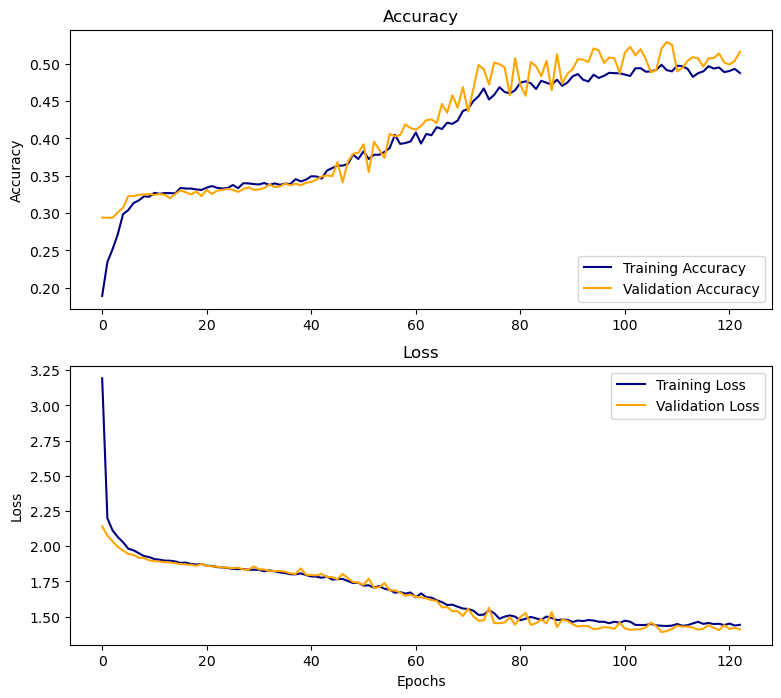

In [209]:
plot_history(hist)

### Model Performance Summary
Below are the final performance metrics for both models that were tested on the tabular audio feature data.

|**Model**|**Accuracy**|
|---|---|
|**Logistic Regression**|0.532|
|**Dense Neural Network (DNN)**|0.515|

## Conclusions
### Spotify Tabular Audio Data Summary
- In this notebook we reviewed tabular audio feature data from Spotify's web API.
- We processed the data to be the correct format to train both logistic regression and dense neural network models.
- We achieved a test-case accuracy of 0.532, an improvement over the base case accuracy of 0.125.
- With further iteration, these models could be improved. However, using this tabular data requires music preprocessing to find the features used for fitting, which takes time and resources.
- Additionally, during this process the genre itself could be surmised during preprocessing.
- This study will be used to compare the neural networks that process raw audio data in the other notebooks.